## Introduction
I downloaded 5,000 RSV fasta sequences+their metadata from GISAID. Sample collection dates span from December 2011 to April 2023. 

I will analyze both the metadata and the sequence data.
## EDA
We will first analyze the metadata of the RSV fasta sequences.

In [1]:
#import functions from python driver file
from metadata_rsv import *
from graph_rsv import *
from blast_class import *

#force clean formatting
set_seaborn_formatting()

In [2]:
#Data extracted from fasta headers
#Summary of all gisaid data
rsv_df,subtype_extraction,rsv_by_country,isp_num,collection_year_df=variants_over_time('gisaid_data/metadata.txt')
rsv_df.head()

,variant_name,epi_isl,collection_date
0,hRSV/A/England/200181047/2019,EPI_ISL_11428301,2019-12-30
1,hRSV/B/England/154800187/2015,EPI_ISL_11428307,2015-11-20
2,hRSV/B/England/160120944/2016,EPI_ISL_11428308,2016-01-04
3,hRSV/A/England/160340212/2016,EPI_ISL_11428309,2016-01-19
4,hRSV/B/England/160360133/2016,EPI_ISL_11428310,2016-01-04


The RSV metadata from GISAID contains the variant name, the unique ID of the submission on GISAID (EPI ISL number), and the date the sample was **collected**.
## Variant Name Breakdown

A lot of information is held in a properly named RSV variant/subtype:

The vast majority of RSV variants can be categorized into RSVA or RSVB. These variants differ from each other clinically and sequentally. Lets breakdown the RSVA and RSVB percentages found in our GISAID sequences.

In [3]:
#extract variant typing
A_subtype_freq='{:.2%}'.format(subtype_extraction.count("A")/len(subtype_extraction))
B_subtype_freq='{:.2%}'.format(subtype_extraction.count("B")/len(subtype_extraction))

print("RSVA",A_subtype_freq,"\nRSVB",B_subtype_freq)

RSVA 47.22% 
RSVB 52.78%


RSVB is slightly more dominant than RSVA in our dataset. Is this true year-to-year?

In [4]:
#round dates up to MM/YY instead of MM/DD/YY for cleaner figs
rsv_df["simple_variant_name"]=get_names_simple(rsv_df["variant_name"])
rsv_df["ocurrence_counter"]=1
rsv_df["collection_month_year"] = rsv_df["collection_date"].astype("datetime64[M]")

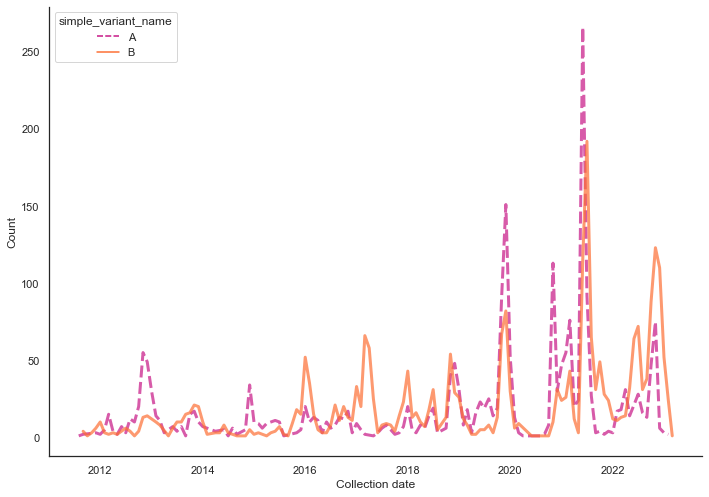

In [5]:
grouped_by_variant=rsv_df.groupby(["simple_variant_name","collection_month_year"]).sum().reset_index()

ax=graph_lineplot(df=grouped_by_variant, x="collection_month_year",y="ocurrence_counter",
             hue="simple_variant_name",style="simple_variant_name",order=["B","A"],
             pal=c_pal,linewidth=3,alpha=.7,linestyle="-")

RSVA and RSVB appear to trade off in dominance year to year, but this graph is a little hard to read. A different visualization might be more effective in displaying this relationship. I will use a KDE.

In [6]:
#submission counts per mm/yy instance
rsv_month_year_counter=dict(zip(grouped_by_variant["collection_month_year"],
                                grouped_by_variant["ocurrence_counter"]))

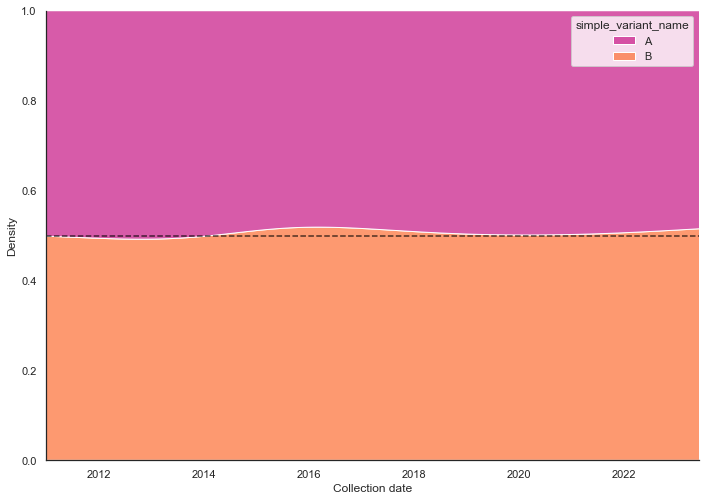

In [7]:
#use rsv_month_year_counter to split rsva and rsvb freqs per mm/yy instance
grouped_by_variant["frequency_counter"]=[item/rsv_month_year_counter[grouped_by_variant["collection_month_year"
                                                                                       ].iloc[i]]
                                         for i, item in enumerate(grouped_by_variant["ocurrence_counter"])]
#add benchmarks to exclude malformed dates
end=datetime.strptime("06/06/23", '%m/%d/%y')
start=datetime.strptime("01/01/11", '%m/%d/%y')

ax=graph_kde(df=grouped_by_variant,x="collection_month_year",hue="simple_variant_name",pal=c_pal,
             start=start,end=end)


The difference in RSVA and RSVB frequency year-by-year is more subtle than it appeared in the lineplot. There is never a differential larger than 5%. 

Through most of our dataset RSVB is either equal to or slightly dominant over RSVA.

## Country of origin breakdown

When submitting to GISAID the date **and** country of origin are required. We will now examine the country of origin of our sequence dataset. Even though GISAID is one of largest sequence databases, there will be locational biases in our datset.

In [8]:
%%capture
#graph country submission data
set_fig_labels(xlabel="Submitting Country",ylabel="Submission Count",
               title="RSV GISAID Submissions, by Country")

country_barplot=graph_barplot(rsv_by_country.iloc[0:10],y="Country",x="Submission count",
                              pal=sns.color_palette('YlOrRd_r',n_colors=10))


In [9]:
%%capture
#generalize countries to continents
continent_df=country_to_continent(rsv_by_country)

#graph continent submission data
set_fig_labels(xlabel="Submitting Continent",ylabel="Submission Count",
               title="RSV GISAID Submissions, by Continent")

continent_barplot=graph_barplot(continent_df,y=continent_df.index,x="Submission count",
                              pal=sns.color_palette('YlOrRd_r',n_colors=10))

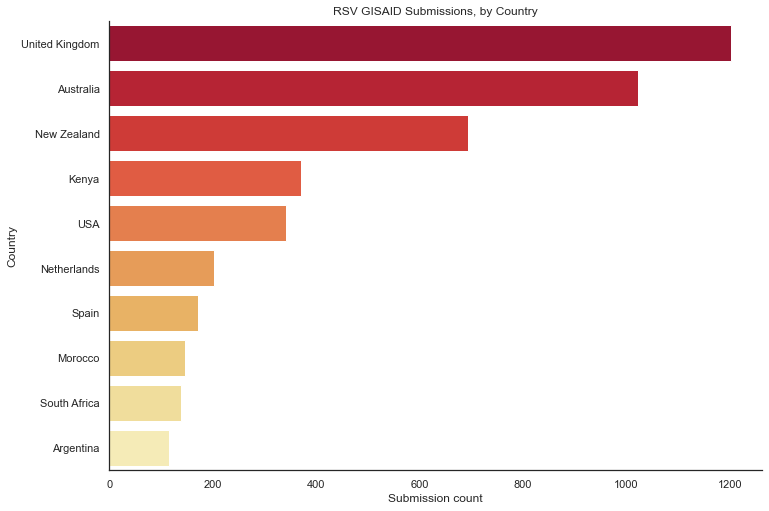

In [10]:
country_barplot

I've limited this examination to the top ten submitters. Countries after this point have less than 100 submissions over a 10+ year period. 
* 6/10 top submitters are English speaking countries.
* 6/10 top submitters are located in the Northern Hemisphere.

Now lets generalize these submissions to their continent of origin


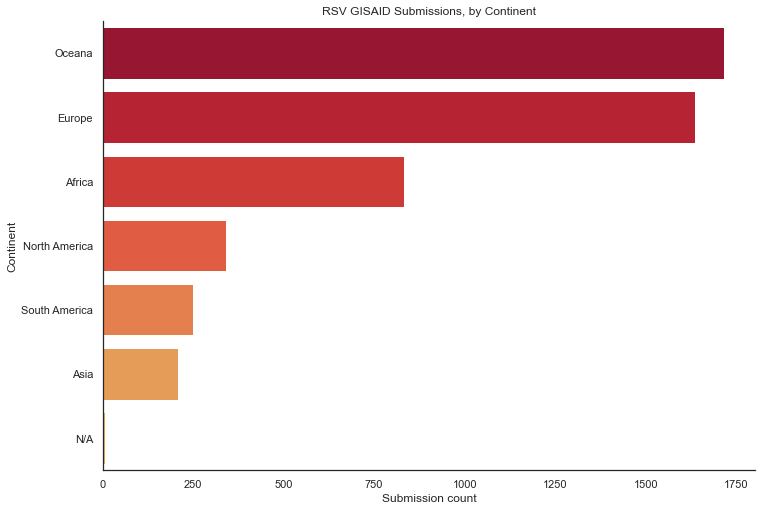

In [11]:
continent_barplot

Overall, our dataset appears to be heavily biased towards Europe and Oceana.

# Collection date breakdown

What conditions make RSV more/less prevalent in certain years, if any?

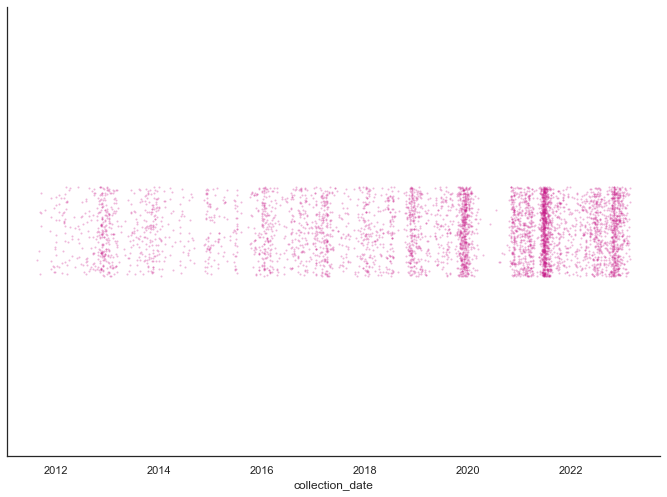

In [12]:
collection_date_stripplot=graph_stripplot(rsv_df,"collection_date",c1)

With this stripplot, the seasonality of RSV is clearly visible. There are lower density areas spaced consistently year-by-year.

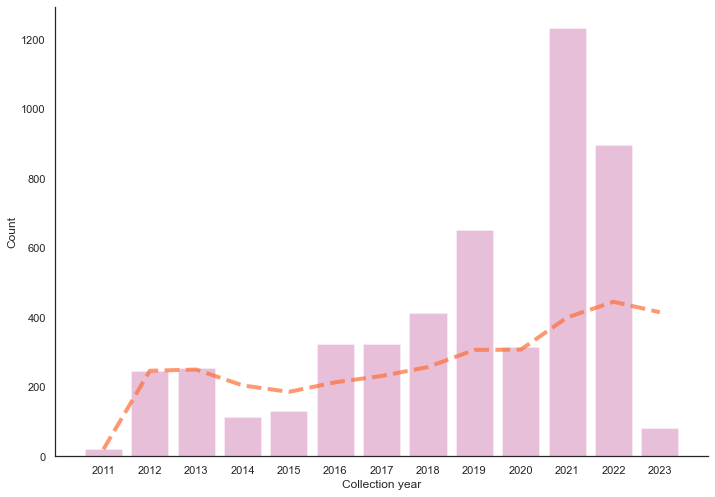

In [13]:
rsv_df["collection_year"]=[item[:item.index("-")] for item in rsv_df["collection_date"].astype(str)]
year_countplot=graph_countplot(df=rsv_df,x="collection_year",average_line=True,bar_color=c1,line_color=c2)

After the emergence of SARS-CoV2 in late 2019, RSV greatly rose in submission count in 2021 and 2022. This data was pulled early April 2023 so it is too early to hypothesize on the trends this year.

# BLAST analysis
Now that we have done some EDA on the metadata of our sequences, lets examine the sequences themselves.

First we will make a database of all our BLAST sequences, using an RSVA sequence as our reference

The following command was run to align our 5,000 sequences to our reference
```%%bash
makeblastdb -in gisaid_rsv_2023_04_13_05.fasta -parse_seqids -dbtype nucl
blastn -query RSVA_ref.fasta -db gisaid_rsv_2023_04_13_05.fasta -num_alignments 5000 -out test_results.txt```

The BLAST alignment results contain a lot of unneeded information, so I'll use a few bash commands to extract the most relevant information.

In [15]:
%%bash
#extract out results, removing alignments
grep -E -v 'Query|Sbjct|    ' blast_results/test_results.txt| grep . > short_results.txt
#remove summary table at start of results
start=$(grep -n ">" short_results.txt | head -n 1 | cut -d ":" -f1)
tail -n +$start short_results.txt > short_results_homology_only.txt


### Sequence Length across variants

Does the length of the RSV genome differ significantly across variants. Particularily in the case of RSVA and RSVB?

In [14]:
cloud_list=create_blast_cloud_from_homology_results("blast_results/short_results_homology_only.txt",">")
#simplify names for graphical purposes
hue_list=cloud_list.get_cloud_names_simple()


Lets see if there is a significant difference in length across our RSV genomes

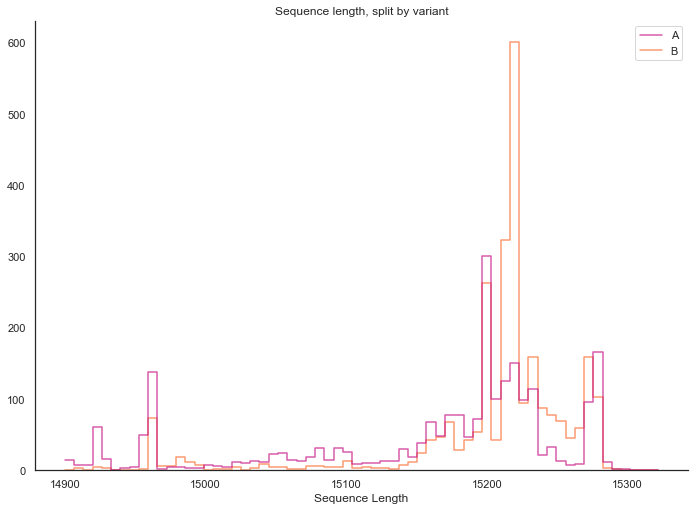

In [15]:
histplot=sns.histplot(x=cloud_list.get_cloud_lengths(),color=c1,alpha=0.7,
                hue=hue_list,
                palette=c_pal, element="step", fill=False)
set_fig_labels(xlabel="Sequence Length",
               title="Sequence length, split by variant",fig=histplot)


The vast majority of sequences are 15,200 bp in length +/- 100 base pairs. However there is a small, but significant subset of genomes with a length between 14,900 and 15,000 base pairs. Most of these genomes are RSVA. 

Visually RSVB seems to have less variance in length vs RSVA. Lets verify this numerically

In [16]:
means=cloud_list.get_cloud_df()[["seq_len","name"]].groupby("name").mean()
stdevs=cloud_list.get_cloud_df()[["seq_len","name"]].groupby("name").std()


print(" RSVA\n mean genome length:", 
      round(means.iloc[0]["seq_len"],2), 
      "base pairs\n standard deviation",
      round(stdevs.iloc[0]["seq_len"],2),"base pairs",
      "\n RSVB\n mean genome length:", 
      round(means.iloc[1]["seq_len"],2), 
      "base pairs\n standard deviation",
      round(stdevs.iloc[1]["seq_len"],2),"base pairs")

 RSVA
 mean genome length: 15158.97 base pairs
 standard deviation 101.98 base pairs 
 RSVB
 mean genome length: 15204.07 base pairs
 standard deviation 68.45 base pairs


The average RSVA genome length is indeeed lower than the average RSVB genome length and subject to much more standard deviation

### Homology across variants
Does alignment homology differ significantly across RSV variants?

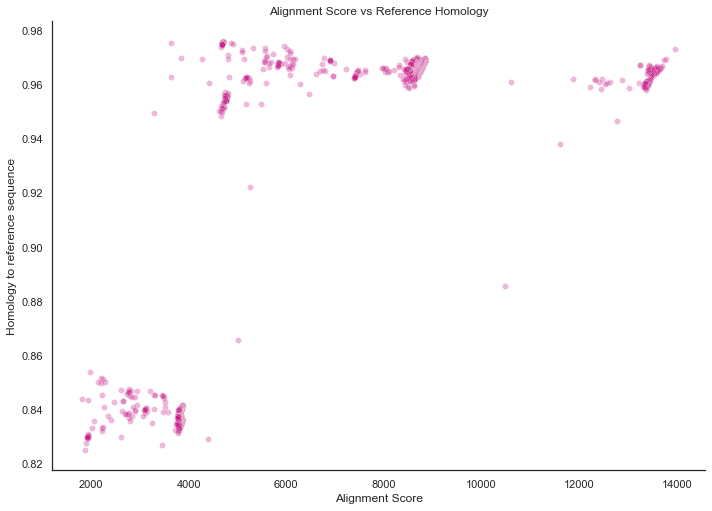

In [17]:
set_fig_labels(xlabel="Alignment Score",ylabel="Homology to reference sequence",
               title="Alignment Score vs Reference Homology")
ax=graph_scatterplot(df=None,x=cloud_list.get_cloud_scores(),y=cloud_list.get_cloud_homologies(),color=c1)


The fasta sequences are clustering into two seperate homology groups. Since we are using a **RSVA** reference we can reasonably guess that the RSVB reference/sequences would lie in this lower homology cluster. This can be easily confirmed with another alignment.

The following command was run to align our RSVB reference to our RSVA reference:

```!blastn -subject RSVA_ref.fasta -query RSVB_ref.fasta -evalue 100 -num_alignments 5000 -out referece_aln.txt```

The below bash commands were then used to trim the BLAST results

In [20]:
%%bash
#extract out results, removing alignments
grep -E -v 'Query|Sbjct|    ' referece_aln.txt| grep . > short_reference_aln.txt
#remove summary table at start of results
start=$(grep -n ">" short_results.txt | head -n 1 | cut -d ":" -f1)
tail -n +$start short_reference_aln.txt > short_reference_aln_homology_only.txt


grep: referece_aln.txt: No such file or directory


In [18]:
#combine two blast runs into one df
ref_cloud_df=create_blast_cloud_from_homology_results("blast_results/short_referece_aln_homology_only.txt",
                                                    "Strand",one_node=True).get_cloud_df()
cloud_df=cloud_list.get_cloud_df()
all_df=pd.concat([cloud_df,ref_cloud_df])

hue=cloud_list.get_cloud_names_simple()+["C"]
color_list=[c1,c2,"grey"]
size_list=[0.1]*(len(all_df)-1)+[50]

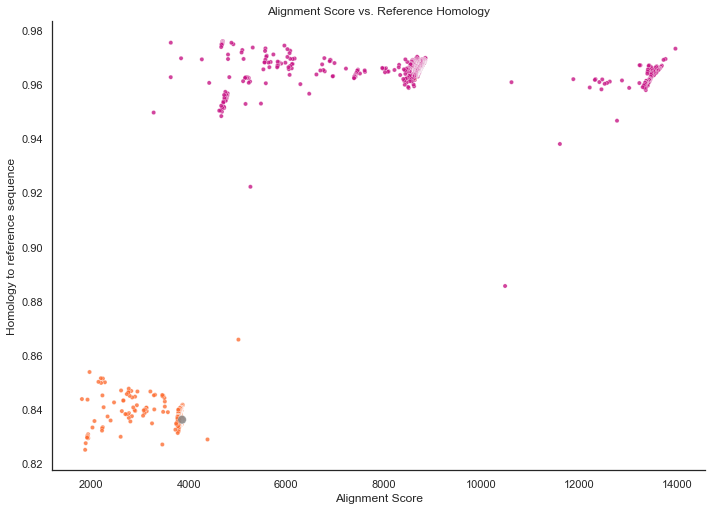

In [19]:
set_fig_labels(xlabel="Alignment Score",ylabel="Homology to reference sequence",
               title="Alignment Score vs. Reference Homology")
ax=graph_scatterplot(df=all_df,x="score",y="homology",pal=color_list,alpha=0.8,
                     hue=hue,size=size_list)


The RSVB reference does appear in the bottom left cluster, as predicted

RSVA and RSVB appear to be classifiable with these two features. Let us verify RSVA and RSVB are classifiable by their features, and if yes which features are the most valuable in said classification process.
### Classification validity

In [20]:
X=cloud_df.drop("name",axis=1)
y=cloud_df["name"].replace("A",0).replace("B",1)
#controlling random state makes results reproducable
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32)

In our data we will use binary classification with the following parameters:
- RSV**A**=0
- RSV**B**=1

Now we will determine the validity of our training and test split

In [21]:
print("Training data split\n",y_train.value_counts(normalize=True))
print("\nTest data split\n",y_test.value_counts(normalize=True))


Training data split
 1    0.527555
0    0.472445
Name: name, dtype: float64

Test data split
 1    0.528529
0    0.471471
Name: name, dtype: float64


The training and test data have the same ratios of RSVA to RSVB

### Optimizing our parameters with grid search 

Grid search creates optimal input parameters for our classification algorithms
#### Random forest

In [22]:
random_forest_params = {'max_features':['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}

random_forest_feats,random_forest_critereon=grid_search(RandomForestClassifier(n_estimators=1000),
                                                       random_forest_params,X_train,y_train)
random_forest = RandomForestClassifier(max_features=random_forest_feats,criterion=random_forest_critereon)

print("We will be using", random_forest_feats, "feature maximalization and", 
      random_forest_critereon, "critereon with random forest")


We will be using sqrt feature maximalization and gini critereon with random forest


#### K Nearest Neighbor

In [23]:
k_nn_neighbors=grid_search(KNeighborsClassifier(),
                                      {'n_neighbors': np.arange(1, 10)},
                                      X_train,y_train)

k_nn = KNeighborsClassifier(n_neighbors = k_nn_neighbors[0])
print("We will have", k_nn_neighbors[0], "neighbors with KNN")

We will have 3 neighbors with KNN


#### Linear Discriminant Analysis

In [24]:

warnings.filterwarnings('ignore')
lda_solver=grid_search(LinearDiscriminantAnalysis(),
                                      {'solver':['svd', 'lsqr', 'eigen']},
                                      X_train,y_train)

LDA = LinearDiscriminantAnalysis(solver = lda_solver[0])

print("We will use the", lda_solver[0], "solver with LDA")


We will use the svd solver with LDA


Now that our input parameters have been optimized, we can actually run our classifiers on our test data

In [25]:
res=[]
for clf in [LDA,k_nn,random_forest]:
    name=clf.__class__.__name__
    results=calculate_scores(clf,X_train, y_train,X_test,y_test)
    res.append(calculate_scores(clf,X_train, y_train,X_test,y_test))
classification_res=pd.DataFrame(res,columns=["Name",'Accuracy','Precision','Recall','Fscore'])


In [26]:
classification_res

,Name,Accuracy,Precision,Recall,Fscore
0,LinearDiscriminantAnalysis,99.70%,99.70%,99.69%,99.70%
1,KNeighborsClassifier,99.60%,99.61%,99.59%,99.60%
2,RandomForestClassifier,99.70%,99.70%,99.69%,99.70%


All classifiers performed extremely similarly with RandomForest and LDA slighly outperforming KNN. This difference is not large enough to be significant.


As we suspected it is possible to classify RSVA and RSVB sequence easily with the data at hand. Now we can test if all of our features have equal weight in the classification process with some regression. 

### Linear Regression to determine feature weights
Since Random Forest was one of our top classifiers, I will use it as our regression model carrying over our grid search parameters when possible

In [29]:
random_forest_regression = RandomForestRegressor(max_features='sqrt')
# fit the model
names=[name.replace("_"," ").capitalize() for name in X.columns]
score=[]
random_forest_regression.fit(X, y)
# get importance
feature_importance = random_forest_regression.feature_importances_
# summarize feature importance
for i,v in enumerate(feature_importance):
    score.append(v)

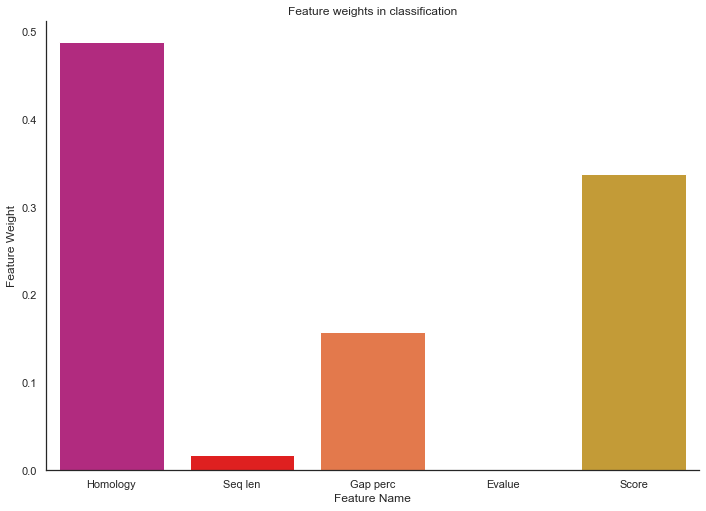

In [30]:
set_fig_labels(xlabel="Feature Name",ylabel="Feature Weight",title="Feature weights in classification")
ax=graph_barplot(df=None,y=score,x=names,pal=[c1,"red",c2,"0","goldenrod"])


Unsuprisingly, homology is the most important feature. Score and alignment gaps (gap_perc) are closely related to homology so their high ranking makes sense. Sequence length and E-value are largely unimportant